In [5]:
import tensorflow as tf

def generate_circles(circles_count, width, height):
  """
  Generates circles with random x, y and radius values that are wholly inside the image.

  Args:
  circles_count: int, number of circles to generate.
  width: int, width of the image.
  height: int, height of the image.

  Returns:
  A tensor of shape (circles_count, 3) where the last dimension is [x, y, radius].
  """
  width = tf.cast(width, tf.float32)
  height = tf.cast(height, tf.float32)
  x = tf.random.uniform([circles_count], maxval=width, dtype=tf.float32)
  y = tf.random.uniform([circles_count], maxval=height, dtype=tf.float32)
  radius = tf.random.uniform([circles_count], maxval=tf.minimum(width, height) / 2, dtype=tf.float32)
  circles = tf.stack([x, y, radius], axis=1)
  return circles


In [6]:
import tensorflow as tf

def generate_circle_images(circles, width, height):
  """
  Generates a grayscale images of given width and height with one circle per image.

  Args:
  circles: tensor of shape (n, 3), the circles with [x, y, radius] values.
  width: int, width of the image.
  height: int, height of the image.

  Returns:
  A tensor of shape (n, height, width) representing the grayscale image.
  """

  # create a meshgrid of x and y coordinates
  x, y = tf.meshgrid(tf.linspace(0.0, width-1, width), tf.linspace(0.0, height-1, height))

  x = tf.cast(x, tf.float32)
  y = tf.cast(y, tf.float32)

  # repeat x for every image
  x = tf.tile(x[tf.newaxis, ...], [circles.shape[0], 1, 1])

  # repeat y for every image
  y = tf.tile(y[tf.newaxis, ...], [circles.shape[0], 1, 1])

  # repeat the circles for each pixel
  circles = tf.tile(circles[:, tf.newaxis, tf.newaxis, :], [1, width, height, 1])

  # compute the distance from each pixel to each circle
  distance = tf.sqrt(tf.square(x - circles[..., 0]) + tf.square(y - circles[..., 1]))

  # create a mask for each circle
  mask = distance <= circles[..., 2]

  # convert the mask to a float32 tensor
  mask = tf.cast(mask, tf.float32)

  # add the channel dimension to the tensor
  # mask = tf.expand_dims(mask, axis=-1)

  return mask


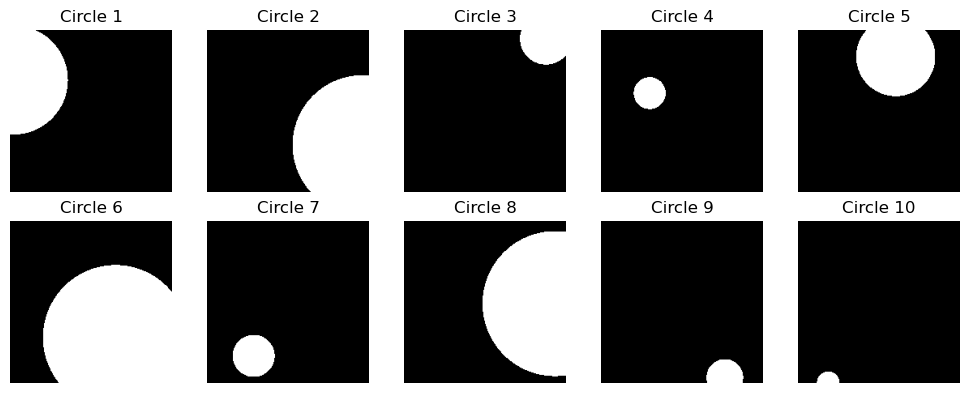

In [12]:
import matplotlib.pyplot as plt


circle_count = 10
width = 200
height = 200
circles = generate_circles(circle_count, width, height)
images = generate_circle_images(circles, width, height)


fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
  ax.imshow(images[i], cmap='gray')
  ax.set_title(f'Circle {i+1}')
  ax.axis('off')
plt.tight_layout()
plt.show()


In [8]:
import tensorflow as tf

class CustomDense(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super(CustomDense, self).__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    self.weights = self.add_weight(
      shape=(input_shape[-1], self.units),
      initializer=tf.keras.initializers.GlorotUniform,
      trainable=True)
    self.bias = self.add_weight(
      shape=(self.units,),
      initializer='zeros',
      trainable=True)
    super(CustomDense, self).build(input_shape)

  def call(self, inputs):
    output = tf.matmul(inputs, self.weights) + self.bias
    
    return output

  def get_config(self):
    config = super(CustomDense, self).get_config()
    config.update({'units': self.units })
    return config

In [9]:
import tensorflow as tf

class CustomReLU(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(CustomReLU, self).__init__(**kwargs)

  def call(self, inputs):
    return tf.nn.relu(inputs)


In [10]:
import tensorflow as tf

class CustomTanh(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(CustomTanh, self).__init__(**kwargs)

  def call(self, inputs):
    return tf.math.tanh(inputs)


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def generate_image(latent_vars, width, height):
  """
  Generates a grayscale image given some latent variables.

  Args:
  latent_vars: tensor of shape (latent_dim,), the latent variables.
  width: int, width of the image.
  height: int, height of the image.

  Returns:
  A tensor of shape (height, width) representing the grayscale image.
  """
  # create a meshgrid of x and y coordinates
  x, y = np.meshgrid(np.linspace(-1, 1, width), np.linspace(-1, 1, height))
  x = tf.constant(x.reshape(-1), dtype=tf.float32)
  y = tf.constant(y.reshape(-1), dtype=tf.float32)

  # repeat the latent variables for each pixel
  latent_vars = tf.tile(latent_vars, [width*height, 1])

  # concatenate the latent variables, x and y coordinates
  inputs = tf.concat([latent_vars, x[:, tf.newaxis], y[:, tf.newaxis]], axis=-1)

  # define the dense layer
  dense = tf.keras.layers.Dense(1, activation='sigmoid')

  # compute the output of the dense layer
  output = dense(inputs)

  # reshape the output to the shape of the image
  image = tf.reshape(output, (height, width))

  return image

# example usage
# latent_vars = tf.random.normal([10])
# image = generate_image(latent_vars, 64, 64)
# plt.imshow(image, cmap='gray')
# plt.show()


InvalidArgumentError: {{function_node __wrapped__Tile_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expected multiples argument to be a vector of length 1 but got length 2 [Op:Tile]